# Step 3) Preparing building data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [8]:
from tsm.categoricals import encode_category

In [170]:
from tsm.data_utils import compress_memory_usage

In [16]:
import pickle

In [9]:
build_data = pd.read_pickle("data/comp/building_metadata.pkl")

In [26]:
NA_REPLACER = {
    'year_built': 9999,
    'floor_count': 99,
}

## Econding Categories

In [12]:
build_data, use_econder = encode_category(build_data, col='primary_use')

In [19]:
with open('data/objects/building_met/adata_primary_use_label_econder.pkl', 'wb') as f_out:
    pickle.dump(use_econder, f_out)

## Missing values

In [28]:
import numpy as np

In [29]:
for col in NA_REPLACER:
    v = NA_REPLACER[col]
    build_data[col].replace(NA_REPLACER[col], np.nan, inplace=True)

In [77]:
# Replace year built with the mean
build_data['year_built'].fillna(build_data.year_built.median(),inplace=True)

### Imptue floor count as a LogRegression of `square_feet` and `year_built`

In [126]:
from sklearn.linear_model import LinearRegression

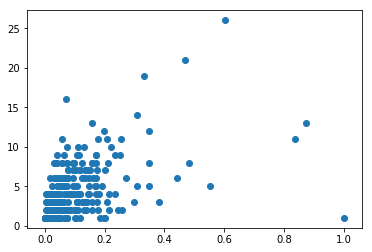

In [145]:
plt.scatter(build_data.square_feet, build_data.floor_count)

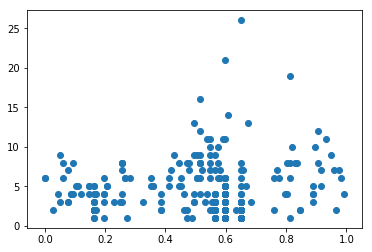

In [146]:
plt.scatter(build_data.year_built, build_data.floor_count)

In [127]:
floor_imputer = LinearRegression()

In [147]:
build_data_no_nan = build_data[~build_data.floor_count.isna()]

In [148]:
build_data_nans = build_data[build_data.floor_count.isna()]

In [149]:
floor_imputer.fit(build_data_no_nan[['square_feet', 'year_built']], np.log1p(build_data_no_nan.floor_count.values.reshape(-1, 1)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [153]:
imputed_floors = np.exp(floor_imputer.predict(build_data_nans[['square_feet', 'year_built']]) - 1).astype(int)

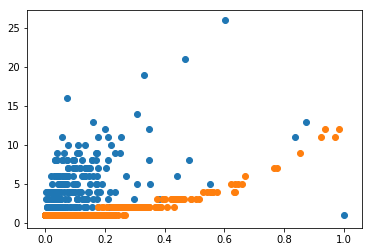

In [154]:
plt.scatter(build_data_no_nan.square_feet, build_data_no_nan.floor_count)
plt.scatter(build_data_nans.square_feet, imputed_floors)

In [155]:
build_data_nans.floor_count = imputed_floors

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [156]:
build_data_no_nas = pd.concat([build_data_nans, build_data_no_nan])

## Normalization

`square_feet` has no missing values so we can start by normalising it

In [51]:
from sklearn.preprocessing import MinMaxScaler

### Square Feet

In [56]:
square_feet_scaler = MinMaxScaler()

In [57]:
square_feet_scaler.fit(build_data.square_feet.values.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [59]:
square_feet_scaler.transform(np.array(10012).reshape(-1, 1))

array([[0.01112245]])

In [60]:
build_data['square_feet'] = square_feet_scaler.transform(build_data.square_feet.values.reshape(-1, 1))

In [61]:
with open('data/objects/building_metadata_square_feet_normalizer.pkl', 'wb') as f_out:
    pickle.dump(square_feet_scaler, f_out)

### Year Built

In [79]:
year_built_scaler = MinMaxScaler()

In [80]:
year_built_scaler.fit(build_data.year_built.values.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [82]:
year_built_scaler.transform(np.array(2010).reshape(-1, 1))

array([[0.94017094]])

In [83]:
build_data['year_built'] = year_built_scaler.transform(build_data.year_built.values.reshape(-1, 1))

In [84]:
with open('data/objects/building_metadata_year_built_normalizer.pkl', 'wb') as f_out:
    pickle.dump(year_built_scaler, f_out)

### Floor Count

In [163]:
floor_count_scaler = MinMaxScaler()

In [164]:
floor_count_scaler.fit(build_data_no_nas.floor_count.values.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [165]:
floor_count_scaler.transform(np.array(10).reshape(-1, 1))

array([[0.36]])

In [166]:
build_data_no_nas['floor_count'] = floor_count_scaler.transform(build_data_no_nas.floor_count.values.reshape(-1, 1))

In [167]:
with open('data/objects/building_metadata_floor_count_normalizer.pkl', 'wb') as f_out:
    pickle.dump(floor_count_scaler, f_out)

In [176]:
build_data_no_nas

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,0.008173,0.923077,0.00
1,0,1,0,0.002786,0.888889,0.00
2,0,2,0,0.005822,0.777778,0.00
3,0,3,0,0.026754,0.871795,0.00
4,0,4,0,0.132985,0.641026,0.00
...,...,...,...,...,...,...
1051,12,1051,0,0.032151,0.598291,0.00
1052,12,1052,11,0.051470,0.598291,0.04
1054,12,1054,0,0.234036,0.598291,0.12
1055,12,1055,0,0.098810,0.598291,0.12


## Finishing

In [177]:
build_data, nas = compress_memory_usage(build_data_no_nas)


Memory usage pre-compression was 0.049747467041015625
Memory usage after-compression was 0.03316497802734375
This is  66.66666666666667% of the initial size


In [178]:
nas

[]

In [179]:
build_data.to_pickle("data/prep/building_metadata.pkl")

### fin